### Simulation: Masternode Yield Farming

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/simulation","")
os.chdir(cwd)

from python.dev.helper import Helper

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor
from python.dev.simulation.batch import ActionBatch
from python.dev.simulation.batch import MergeBatch

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.action import DepositAction
from python.dev.action import LPDepositChainAction
from python.dev.action import DepositChainAction
from python.dev.action import WithdrawChainAction
from python.dev.action import WithdrawAction
from python.dev.action import SwapAction
from python.dev.event import Mint
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.event import Swap

from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import ModelQueue

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

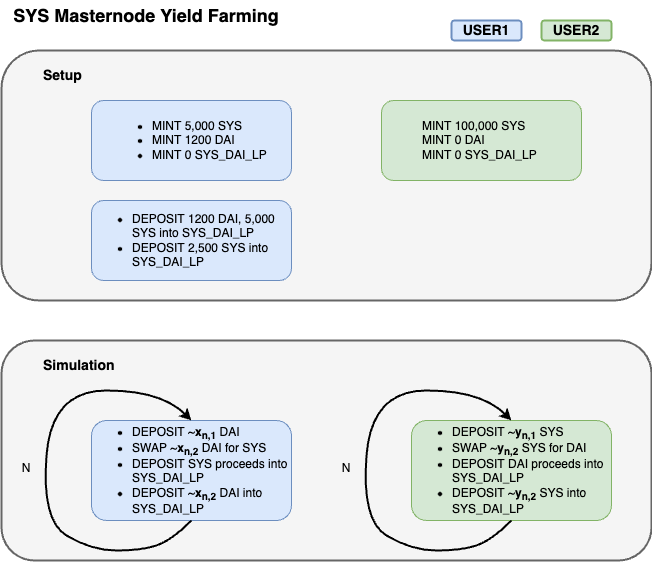

In [2]:
Image("images/jupyter/tutorials/masternode_nft.png", width = 600, height = 600)

### Initialize Agents

In [3]:
USER1 = UserAgent('USER1')
SYS = TokenAgent('SYS')
DAI = TokenAgent('DAI')
SYS_DAI_LP = LiquidityPool('SYS/DAI', USER1, SYS, DAI)
SYS_DAI = LPTokenAgent('SYS_DAI_LP', SYS_DAI_LP)

### Mint Tokens

In [4]:
apy = 0.1
t_delta = 109*24*3600
N_RUNS = 5*365

In [5]:
SYS_mint1 = Mint(5000, apy, True)
DAI_mint1 = Mint(5000, apy, True)
SYS_DAI_LP_mint1 = Mint(0, apy, True)

m_action1 = MintAction(SYS_mint1, SYS, USER1)
m_action2 = MintAction(DAI_mint1, DAI, USER1)
m_action3 = MintAction(SYS_DAI_LP_mint1, SYS_DAI, USER1)

In [6]:
sBatch = ActionBatch('SETUP1')
sBatch.init_action(m_action1)
sBatch.init_action(m_action2)
sBatch.init_action(m_action3)

setup_batch = sBatch.generate()

In [7]:
sBatch.inspect()

** SETUP1 INIT BATCH **
USER1 MINTs 5000.00 SYS 
USER1 MINTs 5000.00 DAI 
USER1 MINTs 0.00 SYS_DAI_LP 


### Setup Actions

### Batchset 2

In [8]:
r_deposit_obj = ModelQueue().apply(np.random.normal(50, 5, N_RUNS))
r_withdraw_obj = ModelQueue().apply(np.random.normal(25, 5, N_RUNS))

r_swap_model = np.random.normal(25, 5, N_RUNS)
r_sub_swap_obj1 = ModelQueue().apply(r_swap_model)
r_sub_swap_obj2 = ModelQueue().apply(r_swap_model)

t_delta_model = TimeDeltaModel().apply(p = 0.00001, n = N_RUNS)
t_delta_obj3 = ModelQueue().apply(t_delta_model)
t_delta_obj4 = ModelQueue().apply(t_delta_model)

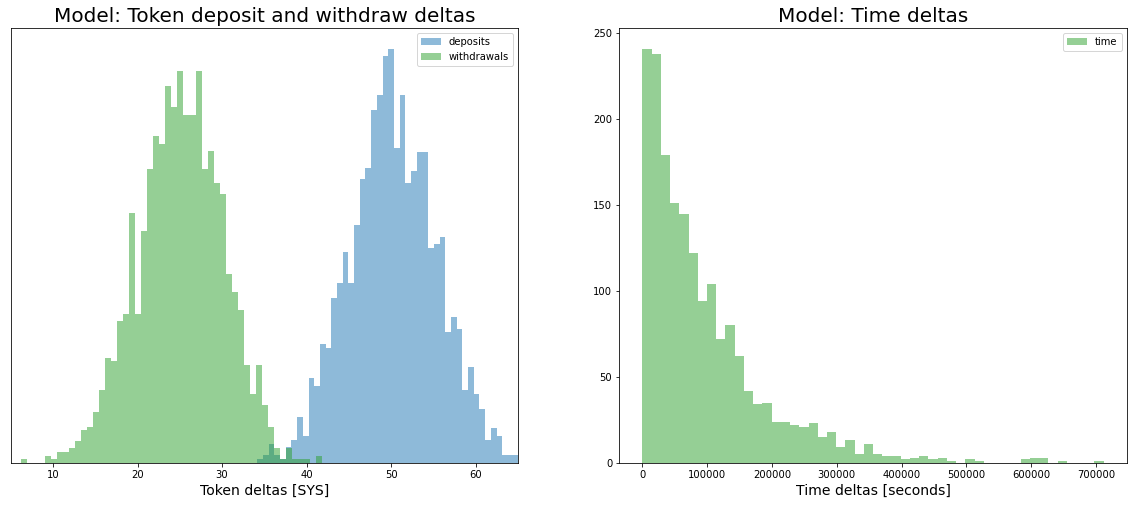

In [9]:
import seaborn as sns
fig, (dist1_ax, dist2_ax) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(20, 8))

r_obj1 = np.random.normal(50, 5, N_RUNS)
r_obj2 = np.random.normal(25, 5, N_RUNS)

blue, _, red = sns.color_palette()[:3]
dist1_ax.hist(r_obj1, 50, color=blue, density=True, alpha=0.5, lw=0, label='deposits');
dist1_ax.hist(r_obj2, 50, color=red, density=True, alpha=0.5, lw=0, label='withdrawals');
dist1_ax.set_xlim(left=0)
dist1_ax.set_xlabel('Token deltas [SYS]', fontsize=14)
dist1_ax.set_yticks([])
dist1_ax.set_xlim(5, 65);
dist1_ax.set_title("Model: Token deposit and withdraw deltas", fontsize=20);
dist1_ax.legend(loc='upper right');

dist2_ax.hist(t_delta_model, 50, color=red, alpha=0.5, lw=0, label='time');
dist2_ax.set_xlabel('Time deltas [seconds]', fontsize=14);
dist2_ax.set_title("Model: Time deltas", fontsize=20);
dist2_ax.legend();

In [10]:
deposit_event = Deposit(apy, r_deposit_obj, t_delta_obj3) 
sub_withdraw_event = Withdraw(apy, r_sub_swap_obj1, 0)
sub_deposit_event = Deposit(apy, r_sub_swap_obj2, t_delta_obj4)
withdraw_event = Withdraw(apy, r_withdraw_obj, 0) 

In [11]:
# Deposit SYS
d_action1 = DepositAction(deposit_event, SYS, USER1, SYS_mint1.get_id())

# Swap SYS for DAI
sub_w_action = WithdrawAction(sub_withdraw_event, SYS, USER1, SYS_mint1.get_id())
sub_d_action = DepositAction(sub_deposit_event, DAI, USER1, DAI_mint1.get_id())
s_action1 = SwapAction(sub_w_action, sub_d_action)

# Withdraw DAI and SYS proceeds 
w_action1 = WithdrawChainAction(s_action1, DAI, USER1, DAI_mint1.get_id())
w_action2 = WithdrawAction(withdraw_event, SYS, USER1, SYS_mint1.get_id())

# Deposit withdrawn DAI and SYS in LP
d_action2 = LPDepositChainAction(w_action1, w_action2, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())

In [12]:
aBatch = ActionBatch('RUN1', N_RUNS)
aBatch.add_action(d_action1)
aBatch.add_action(s_action1)
aBatch.add_action(w_action1)
aBatch.add_action(w_action2)
aBatch.add_action(d_action2)

In [13]:
aBatch.inspect()
action_batch = aBatch.generate()

** RUN1 ACTION BATCH **
USER1 DEPOSITs SYS 
USER1 SWAPs SYS for DAI 
USER1 WITHDRAWs DAI proceeds
USER1 WITHDRAWs SYS 
USER1 DEPOSITs DAI and SYS proceeds into SYS_DAI_LP

 ** REPEAT BATCH ** 
 1825 times

 ** RUNTIME for 1st BATCH ** 
69613 seconds


### Setup event queue

In [14]:
q = EventQueue()
q.add_setup_batch(setup_batch)
q.add_action_batch(action_batch)
q.freeze()

### Execute events

In [15]:
all_batches = q.get_all_batches()

orchestrator = SimulationOrchestrator(verbose = False)
executor = EventExecutor(q, orchestrator)
executor.run()

In [16]:
#orchestrator.print_logs()

### Analyze

In [17]:
tSYS = SYS.get_token()
tDAI = DAI.get_token()
tSYS_DAI = SYS_DAI.get_token()

SYS_addr1 = SYS.get_address(SYS_mint1.get_id())
DAI_addr1 = DAI.get_address(DAI_mint1.get_id())
SYS_DAI_addr1 = SYS_DAI.get_address(SYS_DAI_LP_mint1.get_id())

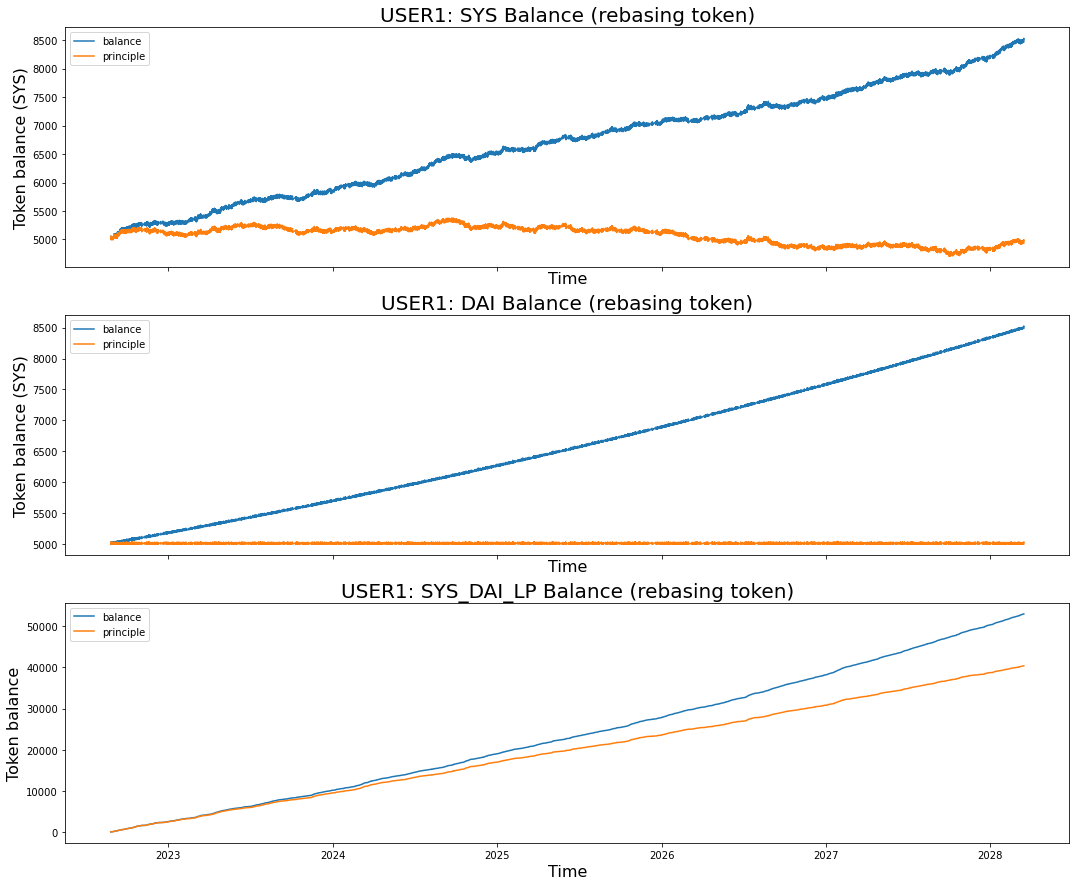

In [18]:
SYS_states1 = tSYS.get_state_series(SYS_addr1)
principle = SYS_states1.get_principle() 
balance = SYS_states1.get_balance() 
tSamp = SYS_states1.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_ax.set_title("USER1: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states1 = tDAI.get_state_series(DAI_addr1)
principle = DAI_states1.get_principle() 
balance = DAI_states1.get_balance() 
tSamp = DAI_states1.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER1: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states1 = tSYS_DAI.get_state_series(SYS_DAI_addr1)
principle = SYS_DAI_states1.get_principle() 
balance = SYS_DAI_states1.get_balance() 
tSamp = SYS_DAI_states1.get_tstamp() 

principle1 = principle
tSamp1 = tSamp

SYS_DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()